### 通过极简方案实现数字识别任务
上一节介绍了创新性的“横纵式”教学法，有助于深度学习初学者快速掌握深度学习理论知识，并在过程中让读者获得真实建模的实战体验。在“横纵式”教学法中，纵向概要介绍模型的基本代码结构和极简实现方案
![](https://ai-studio-static-online.cdn.bcebos.com/dd8d51f8ae634666934841d7fe797a0cda6c8f0ed4434448aafd2ce6082302ff)

在数据处理前，首先要加载飞桨平台与“手写数字识别”模型相关的类库，实现方法如下。

In [2]:
#加载飞桨和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

通过paddle.vision.datasets.MNIST API设置数据读取器，代码如下所示。

In [3]:
# 设置数据读取器，API自动读取MNIST数据训练集
train_dataset = paddle.vision.datasets.MNIST(mode='train')

通过如下代码读取任意一个数据内容，观察打印结果。

<Figure size 640x480 with 0 Axes>

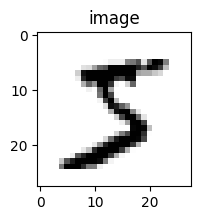

图像数据形状和对应数据为: (28, 28)
图像标签形状和对应数据为: (1,) [5]

打印第一个batch的第一个图像，对应标签数字为[5]


In [4]:
train_data_0 = np.array(train_dataset[0][0])
train_label_0 = np.array(train_dataset[0][1])

# 显示第一batch的第一个图像
import matplotlib.pyplot as plt
plt.figure("Image") # 图像窗口名称
plt.figure(figsize=(2,2))
plt.imshow(train_data_0, cmap=plt.cm.binary)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

print("图像数据形状和对应数据为:", train_data_0.shape)
print("图像标签形状和对应数据为:", train_label_0.shape, train_label_0)
print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(train_label_0))

In [5]:
# 定义mnist数据识别网络结构，同房价预测网络
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        
        # 定义一层全连接层，输出维度是1,28x28=784
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)
        
    # 定义网络结构的前向计算过程
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

In [6]:
# 声明网络结构
model = MNIST()

def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

### 训练过程
训练过程采用二层循环嵌套方式，训练完成后需要保存模型参数，以便后续使用。

- 内层循环：负责整个数据集的一次遍历，遍历数据集采用分批次（batch）方式。
- 外层循环：定义遍历数据集的次数，本次训练中外层循环10次，通过参数EPOCH_NUM设置。

In [7]:
# 图像归一化函数，将数据范围为[0, 255]的图像归一化到[0, 1]
def norm_img(img):
    # 验证传入数据格式是否正确，img的shape为[batch_size, 28, 28]
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    # 归一化图像数据
    img = img / 255
    # 将图像形式reshape为[batch_size, 784]
    img = paddle.reshape(img, [batch_size, img_h*img_w])
    
    return img

In [8]:
import paddle
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

# 声明网络结构
model = MNIST()

def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    loss_list = []
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images = norm_img(data[0]).astype('float32')
            labels = data[1].astype('float32')
            
            #前向计算的过程
            predicts = model(images)
            
            # 计算损失
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了1000批次的数据，打印下当前Loss的情况
            if batch_id % 1000 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    
    return loss_list
            
loss_list = train(model)
paddle.save(model.state_dict(), './dataset/mnist.pdparams')

epoch_id: 0, batch_id: 0, loss is: 35.37991714477539
epoch_id: 0, batch_id: 1000, loss is: 4.342895030975342
epoch_id: 0, batch_id: 2000, loss is: 2.161548614501953
epoch_id: 0, batch_id: 3000, loss is: 2.568909168243408
epoch_id: 1, batch_id: 0, loss is: 5.114665508270264
epoch_id: 1, batch_id: 1000, loss is: 3.4113049507141113
epoch_id: 1, batch_id: 2000, loss is: 4.2501702308654785
epoch_id: 1, batch_id: 3000, loss is: 3.208578109741211
epoch_id: 2, batch_id: 0, loss is: 3.5904321670532227
epoch_id: 2, batch_id: 1000, loss is: 1.8504105806350708
epoch_id: 2, batch_id: 2000, loss is: 4.175838470458984
epoch_id: 2, batch_id: 3000, loss is: 3.164630889892578
epoch_id: 3, batch_id: 0, loss is: 1.7543251514434814
epoch_id: 3, batch_id: 1000, loss is: 1.667447566986084
epoch_id: 3, batch_id: 2000, loss is: 2.691319465637207
epoch_id: 3, batch_id: 3000, loss is: 5.1262311935424805
epoch_id: 4, batch_id: 0, loss is: 1.7251365184783936
epoch_id: 4, batch_id: 1000, loss is: 5.089587211608887


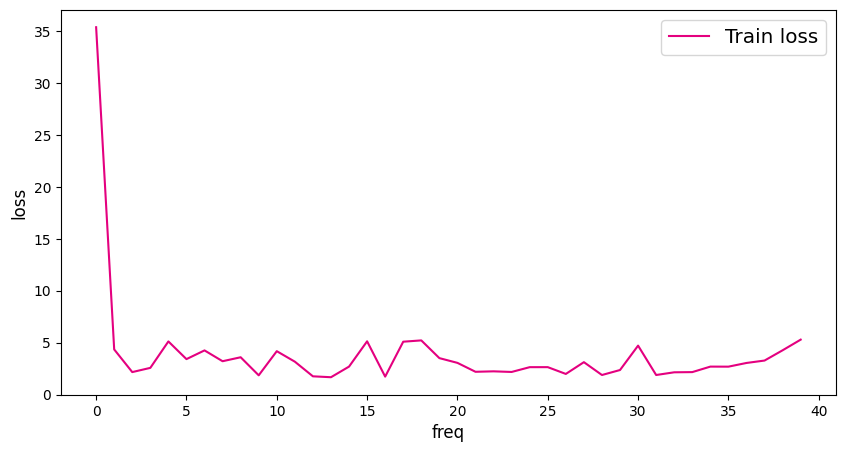

In [9]:
def plot(loss_list):
    plt.figure(figsize=(10,5))
    
    freqs = [i for i in range(len(loss_list))]
    # 绘制训练损失变化曲线
    plt.plot(freqs, loss_list, color='#e4007f', label="Train loss")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("freq", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

plot(loss_list)

### 模型测试
模型测试的主要目的是验证训练好的模型是否能正确识别出数字，包括如下四步：

- 声明实例。
- 加载模型：加载训练过程中保存的模型参数。
- 灌入数据：将测试样本传入模型，模型的状态设置为校验状态（eval），显式告诉框架我们接下来只会使用前向计算的流程，不会计算梯度和梯度反向传播。
- 获取预测结果，取整后作为预测标签输出。

在模型测试之前，需要先从'./work/example_0.png'文件中读取样例图片，并进行归一化处理。

In [10]:
# 导入图像读取第三方库
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img_path = './work/example_0.jpg'
# 读取原始图像并显示
im = Image.open('./work/example_0.jpg')
plt.imshow(im)
plt.show()
# 将原始图像转为灰度图
im = im.convert('L')
print('原始图像shape: ', np.array(im).shape)
# 使用Image.ANTIALIAS方式采样原始图片
im = im.resize((28, 28), Image.ANTIALIAS)
plt.imshow(im)
plt.show()
print("采样后图片shape: ", np.array(im).shape)

FileNotFoundError: [Errno 2] No such file or directory: './work/example_0.jpg'